In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 1 - Uncoupled 3-box w/ and w/o noise

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [56]:
# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi = 2.25         # Noise strength

# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 3

# Initialize forcing vectors and run experiments
scenarios = ['2xCO2','High Emissions','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble = {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}

# Iterate over set of experiments
for i, scen in enumerate(scenarios):
  full_outputs_ensemble[scen], forcings_ensemble[scen], T_out_ensemble[scen] = [], [] ,[]

  # Run deterministic experiments once
  full_outputs_single[scen] = BudykoSellers.Run_Budyko_Sellers(scen_flag=i, n_boxes=n_boxes)
  forcings_single[scen] = np.tile(full_outputs_single[scen]['forcing_ts'], (n_boxes, 1))
  T_out_single[scen] = np.squeeze(full_outputs_single[scen]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[scen].append(BudykoSellers.Run_Budyko_Sellers(scen_flag=i, xi=xi, n_boxes=n_boxes))
    forcings_ensemble[scen].append(np.tile(full_outputs_ensemble[scen][-1]['forcing_ts'], (n_boxes, 1)))
    T_out_ensemble[scen].append(np.squeeze(full_outputs_ensemble[scen][-1]['T_ts'])[0:n_boxes,:])


In [55]:
np.std(T_out_ensemble['2xCO2'][0][1][10:])

np.float64(1.5620158536627078)

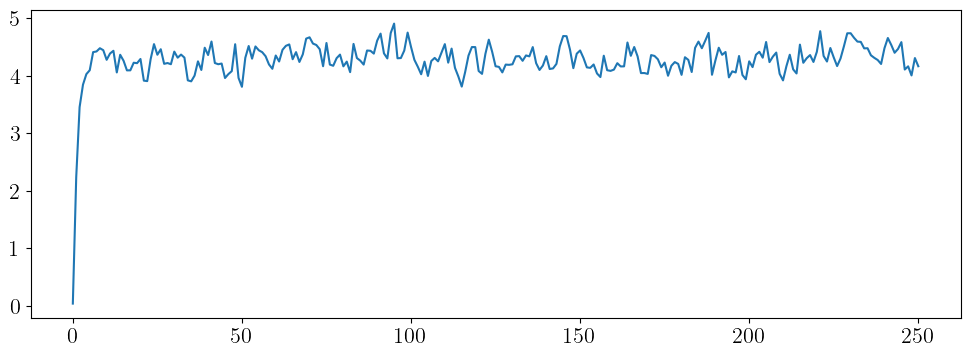

In [57]:
plt.plot(np.mean(np.array(T_out_ensemble['2xCO2']),axis=0)[1])

### Method X: DMD

In [71]:
n_choices = 10
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1

operator_DMD, T_pred_DMD, L2_DMD = emulator_utils.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
operator_true_DMD, operator_ensemble_DMD, operator_L2_avg_DMD, w_pred_L2_DMD = emulator_utils.evaluate_ensemble(scenarios, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'DMD', operator_DMD, w0=w0, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [0.00833993 0.0564331  0.01894922]
	Test: High Emissions - [1.65973213 1.79898953 1.65979923]
	Test: Overshoot - [1.15611372 1.21868451 1.08760037]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [1.15337108 1.14546443 1.06150841]
	Test: High Emissions - [0.00061313 0.00196864 0.00074254]
	Test: Overshoot - [0.97278223 1.91479348 1.69231582]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [0.35646406 2.12927088 0.82352792]
	Test: High Emissions - [0.02622897 0.07353912 0.03321623]
	Test: Overshoot - [0.00109649 0.00155527 0.00120978]


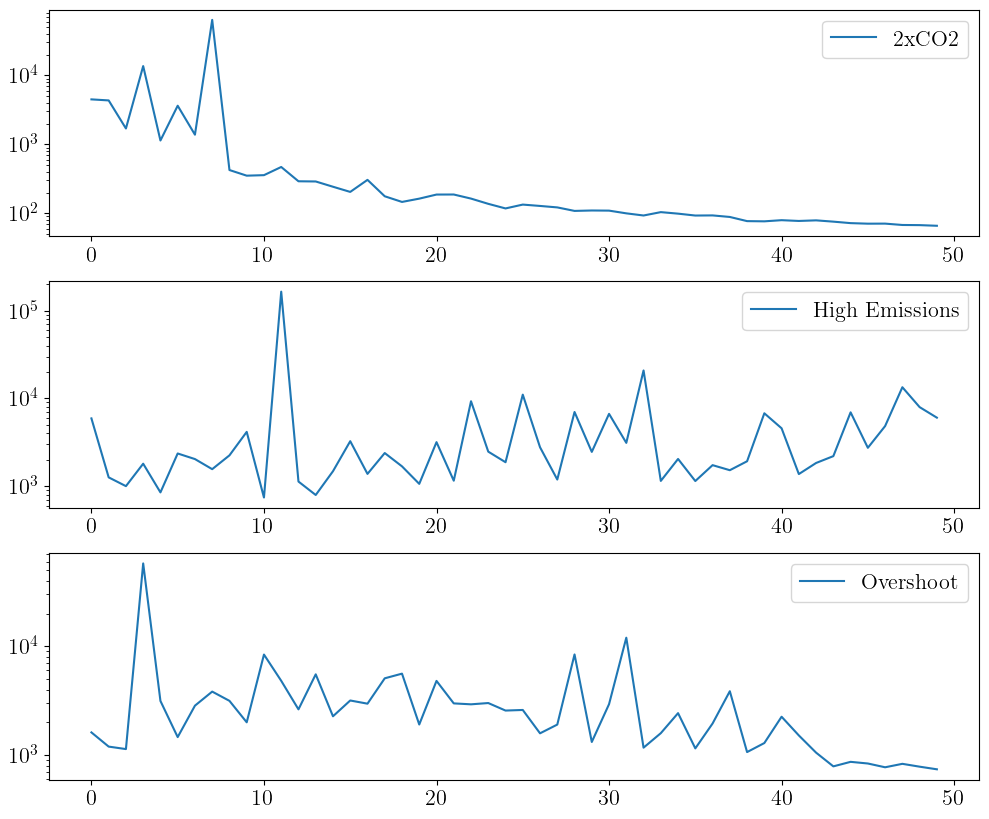

In [73]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, scen1 in enumerate(scenarios):
  ax[i].semilogy(operator_L2_avg_DMD[scen1], label=f'{scen1}')
  ax[i].legend()

In [134]:
w_pred_L2_DMD['2xCO2']

{'2xCO2': [np.float64(106.8392413554055),
  np.float64(100.30551788143357),
  np.float64(5161.533157022654),
  np.float64(1066721.5258253347),
  np.float64(511.1476013617761),
  np.float64(74.3769364197278),
  np.float64(9357.625187172329),
  np.float64(35.52226571424259),
  np.float64(18.514949670062396),
  np.float64(16.65123353674825),
  np.float64(15.656951696859972),
  np.float64(18.830668895758073),
  np.float64(13.451662853351651),
  np.float64(12.702141497656322),
  np.float64(11.728436147440098),
  np.float64(10.158083259993736),
  np.float64(12.34750205428382),
  np.float64(9.010569130116734),
  np.float64(7.727729329885023),
  np.float64(8.106189820199246),
  np.float64(8.805731061339106),
  np.float64(8.774928463864835),
  np.float64(7.775693962867834),
  np.float64(6.784646684146693),
  np.float64(6.100958113934376),
  np.float64(6.5949810501654005),
  np.float64(6.35419102514734),
  np.float64(6.080481596466936),
  np.float64(5.588906580030431),
  np.float64(5.75862308725

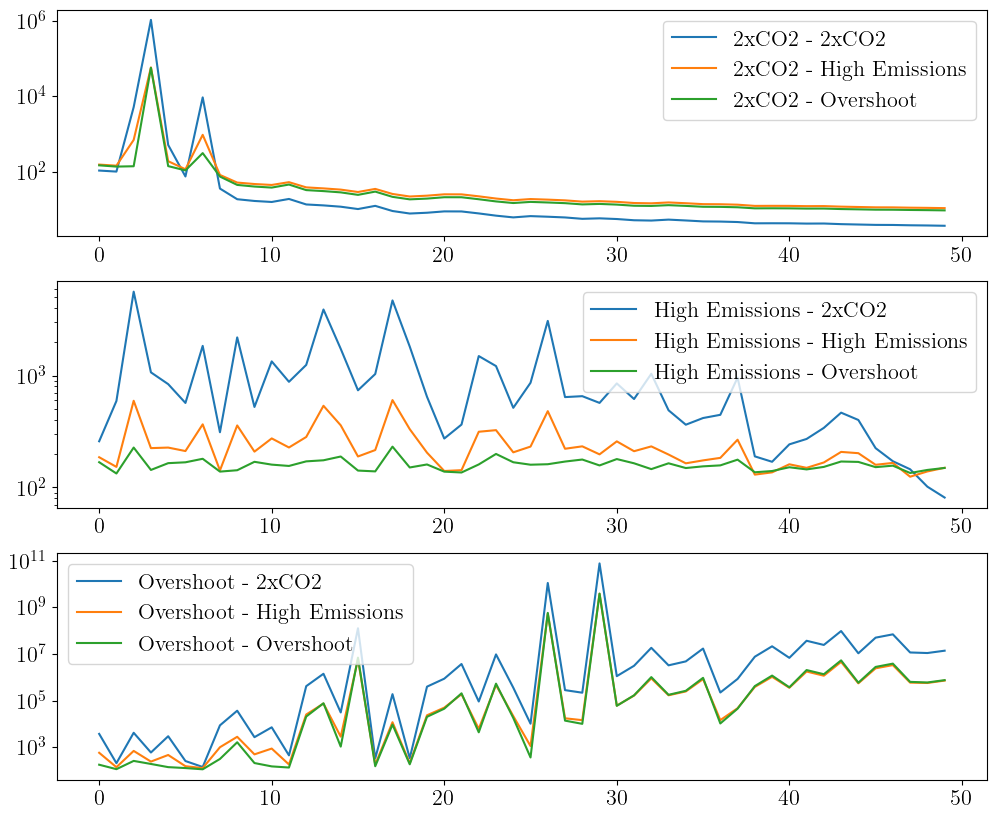

In [74]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, scen1 in enumerate(scenarios):
  for scen2 in scenarios:
    ax[i].semilogy(w_pred_L2_DMD[scen1][scen2], label=f'{scen1} - {scen2}')
  ax[i].legend()

### Method X: EDMD

In [131]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=3)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=3)
operator_EDMD, T_pred_EDMD, L2_EDMD = emulator_utils.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
operator_true_EDMD, operator_ensemble_EDMD, operator_L2_avg_EDMD, w_pred_L2_EDMD = emulator_utils.evaluate_ensemble(scenarios, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'EDMD', operator_EDMD, w_dict=w_dict, F_dict=F_dict, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [ 68.0032512   60.6559528  140.88158424]
	Test: High Emissions - [ 407.9264798   131.00015855 1008.73573591]
	Test: Overshoot - [ 89.96024495 120.60608401 188.25487851]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [  68.00325364  418.48196871 3715.89862589]
	Test: High Emissions - [213.75011133 128.01177252 269.34526719]
	Test: Overshoot - [ 194.8695208   130.49626173 1707.00338196]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [ 68.00325585  59.21530184 590.71240512]
	Test: High Emissions - [213.75011085 128.56449789 258.45376085]
	Test: Overshoot - [194.86952073 109.8162517  208.28708791]


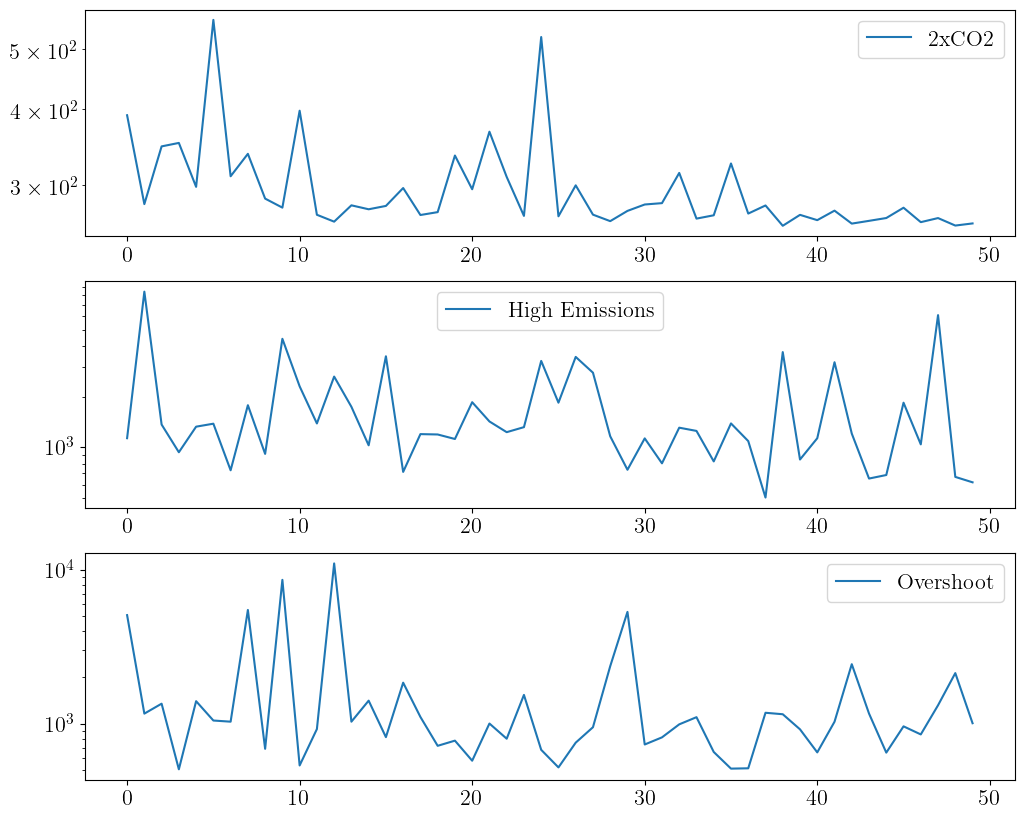

In [132]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, scen1 in enumerate(scenarios):
  ax[i].semilogy(operator_L2_avg_EDMD[scen1], label=f'{scen1}')
  ax[i].legend()

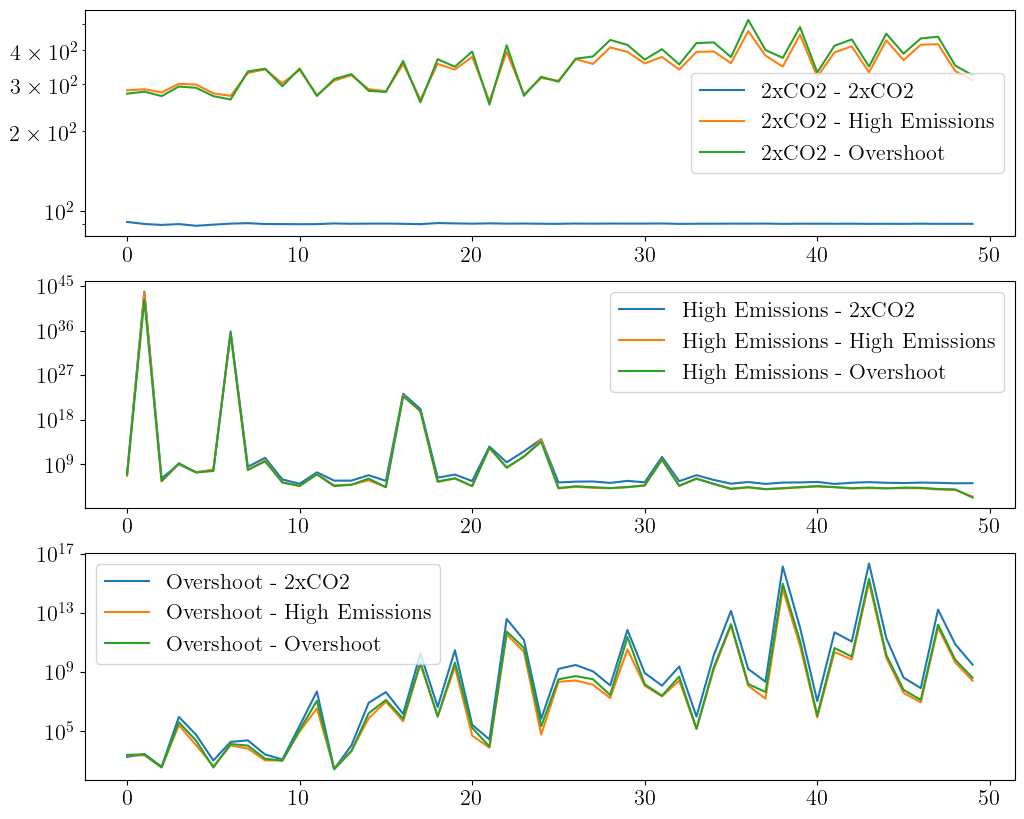

In [133]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, scen1 in enumerate(scenarios):
  for scen2 in scenarios:
    ax[i].semilogy(w_pred_L2_EDMD[scen1][scen2], label=f'{scen1} - {scen2}')
  ax[i].legend()

### Method X: Deconvolution

In [98]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, L2_deconvolve = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single, dt=dt)
operator_true_deconvolve, operator_ensemble_deconvolve, operator_L2_avg_deconvolve, w_pred_L2_deconvolve = emulator_utils.evaluate_ensemble(scenarios, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'deconvolve', operator_deconvolve, dt=dt, regularize=True)


Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [6.42521086e-14 1.13763691e-15 3.57850896e-14]
	Test: High Emissions - [1.62679396 1.75311957 1.62571841]
	Test: Overshoot - [1.13411749 1.19097331 1.06907862]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [1.13727626 1.11642388 1.04144234]
	Test: High Emissions - [8.58999198e-14 9.38031066e-14 1.06939897e-13]
	Test: Overshoot - [0.95639325 1.87097792 1.66369773]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [  99068.10473284 1403815.76887333  744549.39489041]
	Test: High Emissions - [ 7440.68301836 52131.59389136 29541.74302341]
	Test: Overshoot - [1.27897074e-13 1.49553387e-13 1.28938775e-13]


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


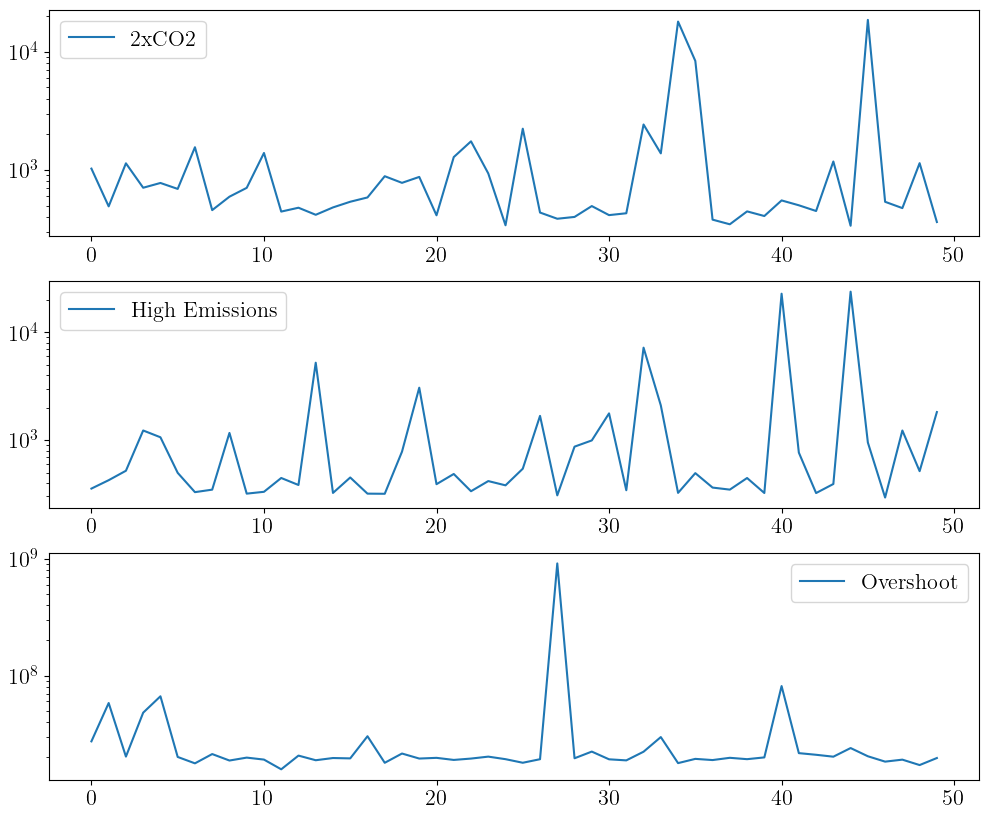

In [102]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, scen1 in enumerate(scenarios):
  ax[i].semilogy(operator_L2_avg_deconvolve[scen1], label=f'{scen1}')
  ax[i].legend()

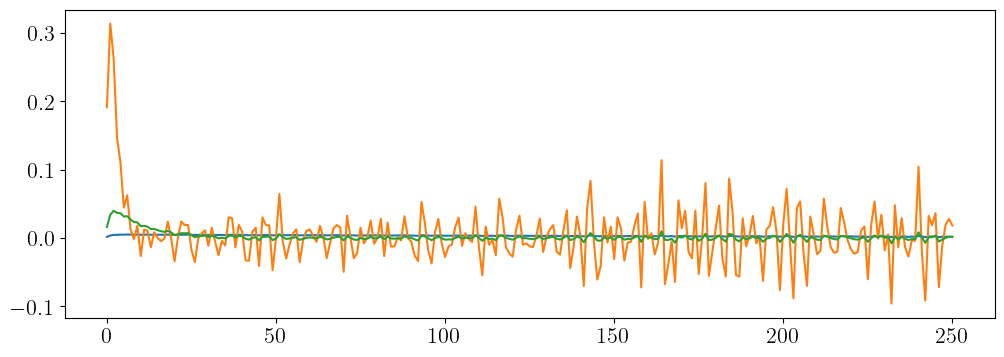

In [143]:
plt.plot(operator_ensemble_deconvolve['2xCO2'][49].T)

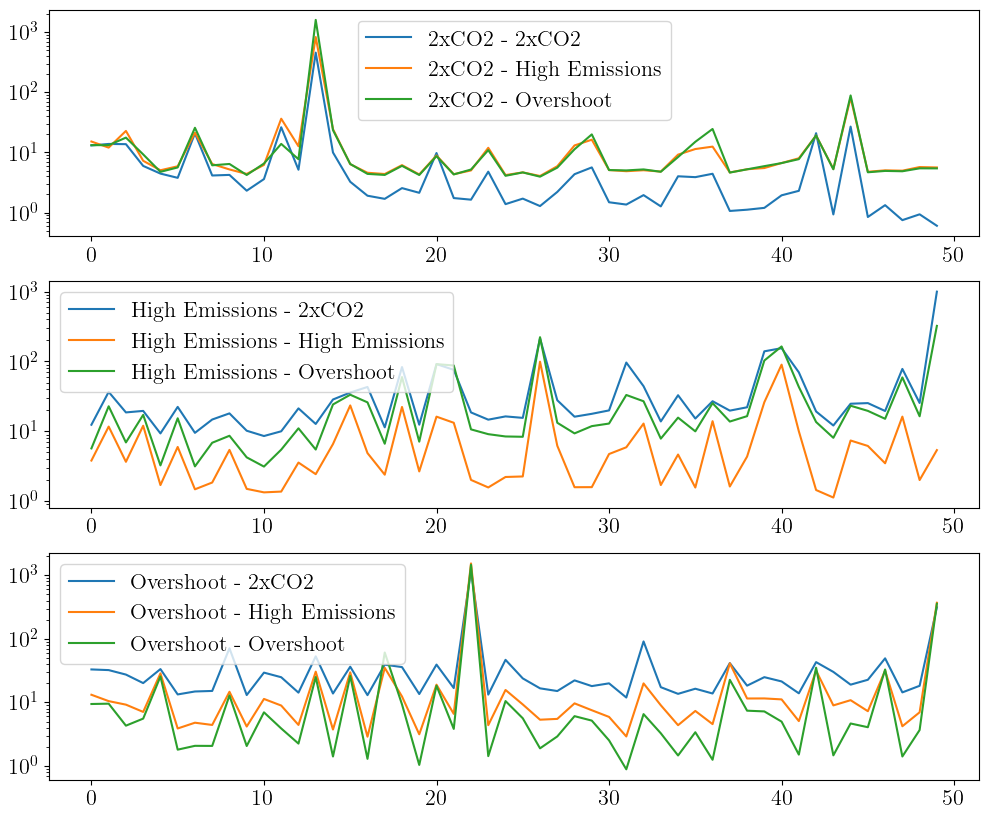

In [81]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, scen1 in enumerate(scenarios):
  for scen2 in scenarios:
    ax[i].semilogy(w_pred_L2_deconvolve[scen1][scen2], label=f'{scen1} - {scen2}')
  ax[i].legend()

### Method X: Direct Diagnosis

In [193]:
n_ensemble = 50
operator_direct, T_pred_direct, L2_direct = emulator_utils.emulate_experiments('direct', experiments=experiments, outputs=T_out_single, forcings=forcings_single, n_boxes=n_boxes, dt=dt)
#emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, experiments)
operator_ensemble_direct, operator_L2_avg_direct = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'direct', operator_direct, t=t, dt=dt, n_boxes=n_boxes, xi=xi)

100%|██████████| 22827/22827 [00:00<00:00, 33474.50it/s]


Train: Impulse Forcing - L2 Error
	Test: 2xCO2 - 1.5730398636794063
	Test: High Emissions - 0.26961399061701136
	Test: Overshoot - 0.9335296520994525


100%|██████████| 22827/22827 [00:00<00:00, 35798.25it/s]
/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:299: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  def Run_Budyko_Sellers(exp_flag=0, diff_flag=0, vert_diff_flag=0, xi=0):
100%|██████████| 22827/22827 [00:00<00:00, 35131.16it/s]


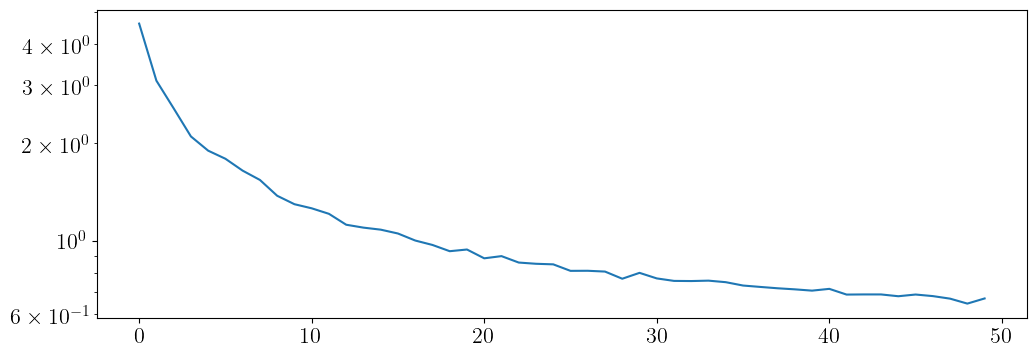

In [194]:
plt.semilogy(operator_L2_avg_direct, label=exp)

### Method X: FDT

In [161]:
#### DO NOT USE
delta = 2
operator_ensemble_FDT, operator_L2_avg_FDT, w_pred_L2_FDT = emulator_utils.evaluate_ensemble(experiments, 5, n_choices, forcings_ensemble, T_out_ensemble, 'FDT', operator_deconvolve, dt=dt, delta=delta, n_boxes=n_boxes, n_steps=n_steps, xi=xi)

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  return out


In [144]:
n_ensemble = 10
operator_FDT, T_pred_FDT, error_metrics_FDT = [], [], []
delta = 2
for n in range(1,n_ensemble + 1):
  operator_FDT_n, T_pred_FDT_n, error_metrics_FDT_n = emulator_utils.emulate_scenarios('FDT', scenarios=scenarios, forcings=forcings_single, outputs=T_out_single, n_ensemble=n, n_boxes=n_boxes, n_steps=n_steps, xi=xi, delta=delta, dt=dt)

  operator_FDT.append(operator_FDT_n)
  T_pred_FDT.append(T_pred_FDT_n)
  error_metrics_FDT.append(error_metrics_FDT_n)

Train: 2xCO2 - L2 Error


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


	Test: 2xCO2 - [157.77874396 151.59069304 142.72502736]
	Test: High Emissions - [243.5612227  239.42562253 239.75993778]
	Test: Overshoot - [250.19555542 212.21383698 218.80680027]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [262.35518119 239.9011742  236.18211049]
	Test: High Emissions - [366.77279945 361.34820438 361.27206328]
	Test: Overshoot - [380.83930945 340.87282506 347.30977576]
Train: Overshoot - L2 Error
	Test: 2xCO2 - [ 92.35301651 101.23783195  83.86859096]
	Test: High Emissions - [140.8846915  138.84975    138.54841667]
	Test: Overshoot - [143.6554764  123.04572326 126.10570784]
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - [88.66169259 91.10611625 81.34534444]
	Test: High Emissions - [125.56643407 123.49223004 123.7086542 ]
	Test: Overshoot - [133.68021135 121.23059717 123.77474862]
Train: High Emissions - L2 Error
	Test: 2xCO2 - [36.72264742 59.51008142 38.6493099 ]
	Test: High Emissions - [52.66971003 52.48545874 51.99014331]
	Test: Overshoot - [51.56520286 43.43016999 44

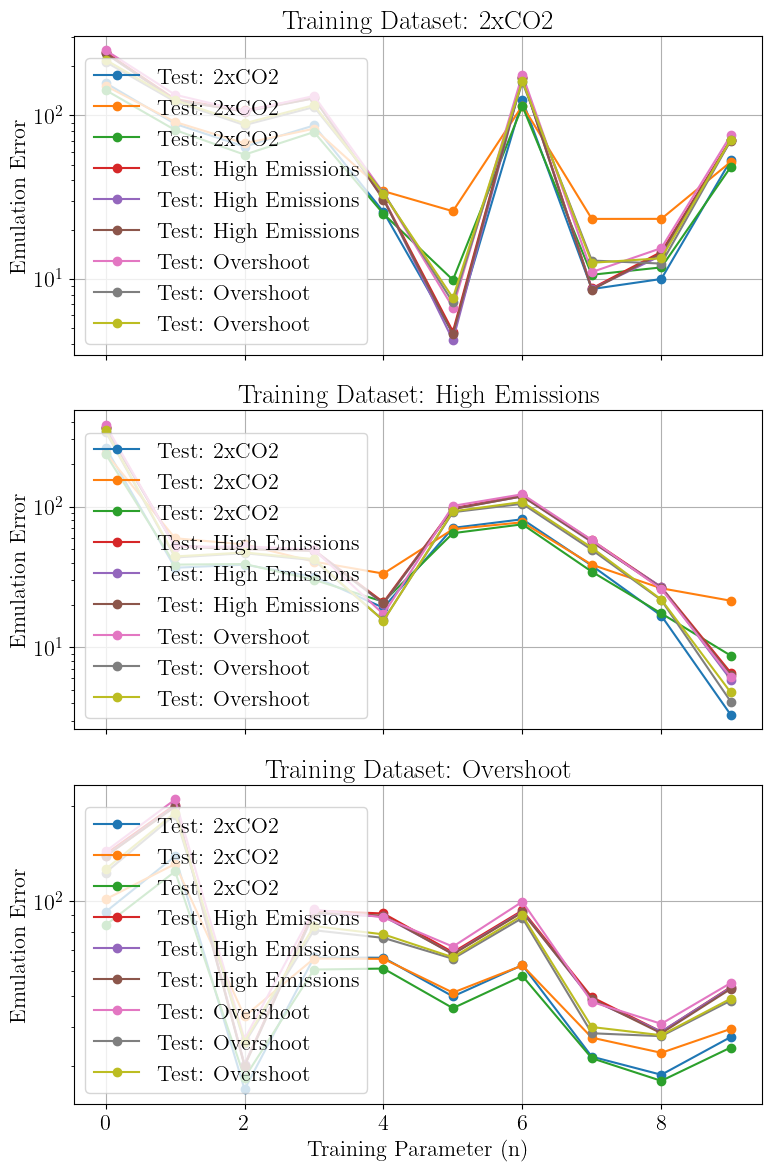

In [145]:
# Number of subplots
num_subplots = len(scenarios)
n_values = np.arange(len(error_metrics_FDT))  # Indices represent the training parameter n

# Create subplots
fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 4 * num_subplots), sharex=True)

if num_subplots == 1:
  axes = [axes]  # Ensure axes is iterable if there's only one subplot

for i, exp1 in enumerate(scenarios):
  ax = axes[i]
  for exp2 in scenarios:
    errors = [entry[exp1][exp2] for entry in error_metrics_FDT]
    ax.semilogy(n_values, errors, marker='o', label=f'Test: {exp2}')

  ax.set_title(f'Training Dataset: {exp1}')
  ax.set_ylabel('Emulation Error')
  ax.legend()
  ax.grid(True)

# Common x-axis label
axes[-1].set_xlabel('Training Parameter (n)')

# Show plot
plt.tight_layout()
plt.show()

### Method X: Exponential Fit

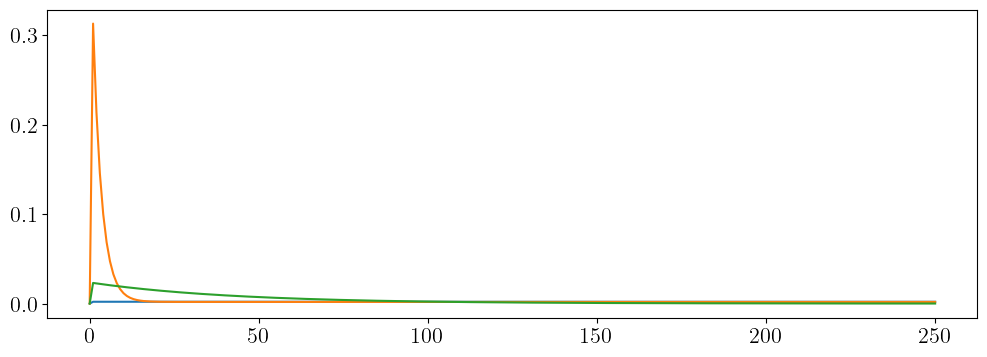

In [190]:
plt.plot(op.T)

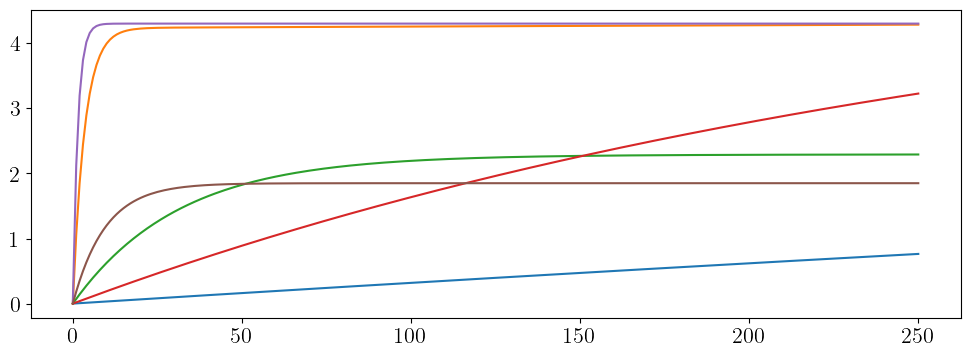

In [193]:
plt.plot(w_est.T)
plt.plot(T_out_single[scen].T)

In [214]:
i = 4
scen = '2xCO2'
op = operator_fit[i][scen]
w_est = emulator_utils.emulate_response(forcings_single[scen], op, dt)
emulator_utils.calc_NRMSE(T_out_single[scen],w_est)

array([5.45649779, 1.25280868, 8.14594118])

In [199]:
len(A)

40

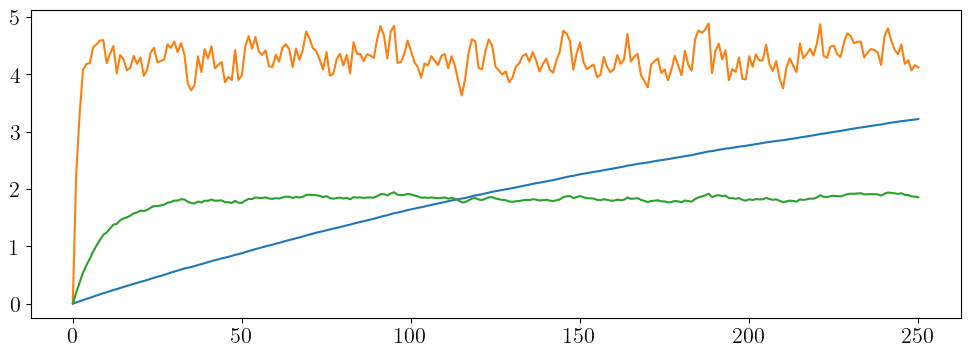

In [206]:
plt.plot(T_choice[n]['2xCO2'].T)

In [203]:
import random
n_ensemble = [1, 10,20,30,40]
forcings_choice, T_choice = [], []
for n, mem in enumerate(n_ensemble):
  forcings_choice.append({})
  T_choice.append({})
  for scen in scenarios:
    forcing_w = list(zip(forcings_ensemble[scen], T_out_ensemble[scen]))
    temp_choice = random.sample(forcing_w, mem)
    A, B = zip(*temp_choice)
    forcings_choice[n][scen] = np.mean(np.stack(A, axis=0), axis=0)
    T_choice[n][scen] = np.mean(np.stack(B, axis=0), axis=0)

operator_fit, T_pred_fit, error_metrics_fit = [], [], []
for n, mem in enumerate(n_ensemble):
  T_out_temp = T_out_ensemble
  operator_fit_n, T_pred_fit_n, error_metrics_fit_n = emulator_utils.emulate_scenarios('fit_amp', scenarios=scenarios, outputs=T_choice[n], forcings=forcings_choice[n], t=t, dt=dt, n_boxes=n_boxes, n_modes=3)

  operator_fit.append(operator_fit_n)
  T_pred_fit.append(T_pred_fit_n)
  error_metrics_fit.append(error_metrics_fit_n)

Train: 2xCO2 - L2 Error
[  5.035134   -13.658921   -12.741974    -9.041912     0.94012415
 -10.659855   -10.199608   -12.639147     4.0256147   -6.0275626
  -1.2278779   -2.925628  ]
	Test: 2xCO2 - [40.33202731 32.68513589 38.23755508]
	Test: High Emissions - [42.76576559 55.13921755 62.84721504]
	Test: Overshoot - [48.53162338 83.54827133 60.71797663]
Train: High Emissions - L2 Error
[  5.9764905 -13.766989  -13.445487   -6.040342    0.9387731 -11.064944
 -11.324119  -13.07071     3.7874615 -10.466904   -1.1279216  -3.6050968]
	Test: 2xCO2 - [39.75675791 38.46324497 56.37276889]
	Test: High Emissions - [54.20421248 54.2152746  29.53315073]
	Test: Overshoot - [69.00700746 82.86269214 56.26489424]
Train: Overshoot - L2 Error
[  6.1850104 -13.792887  -13.517596   -6.278352    0.7827811 -11.067916
 -11.517577  -13.177922    3.745496  -10.199584   -0.9546556  -3.7471673]
	Test: 2xCO2 - [53.41933615 34.61398979 83.24104128]
	Test: High Emissions - [69.42458927 55.14894304 49.14768661]
	Test

In [162]:
error_metrics_fit

[{'2xCO2': {'2xCO2': array([203.16753456,  78.42418669, 136.19335937]),
   'High Emissions': array([222.43215695,  77.29546178, 138.49470563]),
   'Overshoot': array([167.44675414,  86.31865433, 134.0042439 ])},
  'High Emissions': {'2xCO2': array([ 70.47015073,  78.60286992, 156.36000787]),
   'High Emissions': array([ 79.77895862,  77.01806689, 159.4817091 ]),
   'Overshoot': array([ 49.0574666 ,  86.15290053, 153.31310843])},
  'Overshoot': {'2xCO2': array([142.52557209,  78.48499077,  48.71133262]),
   'High Emissions': array([152.98192161,  76.97644521,  42.62862922]),
   'Overshoot': array([123.73560672,  85.6162025 ,  39.01828985])}},
 {'2xCO2': {'2xCO2': array([130.84487293,  74.42138857,  29.63488123]),
   'High Emissions': array([112.82406219,  65.31647259,  25.46244045]),
   'Overshoot': array([187.89203077, 102.40964911,  46.56433912])},
  'High Emissions': {'2xCO2': array([99.14946476, 74.2994657 , 54.94949952]),
   'High Emissions': array([83.87569808, 64.50927715, 57.388

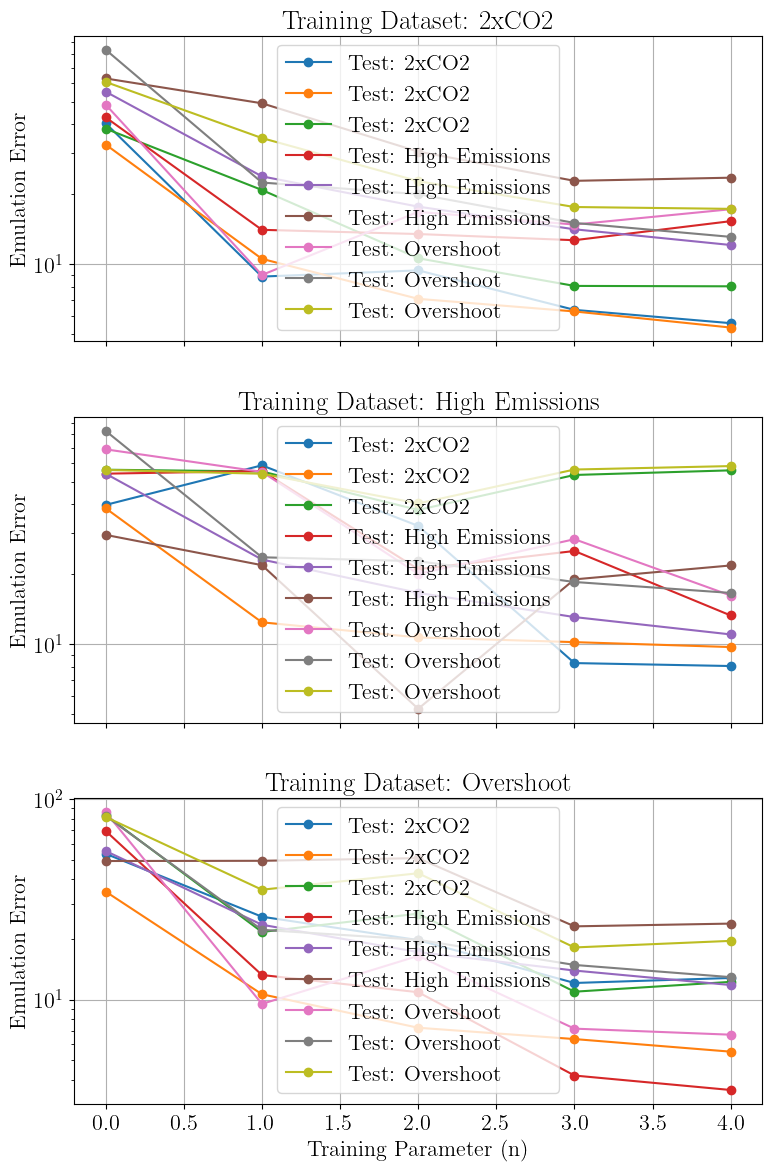

In [215]:
# Number of subplots
num_subplots = len(scenarios)
n_values = np.arange(len(error_metrics_FDT))  # Indices represent the training parameter n

# Create subplots
fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 4 * num_subplots), sharex=True)

if num_subplots == 1:
  axes = [axes]  # Ensure axes is iterable if there's only one subplot

for i, exp1 in enumerate(scenarios):
  ax = axes[i]
  for exp2 in scenarios:
    errors = [entry[exp1][exp2] for entry in error_metrics_fit]
    ax.semilogy(errors, marker='o', label=f'Test: {exp2}')

  ax.set_title(f'Training Dataset: {exp1}')
  ax.set_ylabel('Emulation Error')
  ax.legend()
  ax.grid(True)

# Common x-axis label
axes[-1].set_xlabel('Training Parameter (n)')

# Show plot
plt.tight_layout()
plt.show()

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [  42.58759338  363.40770065  -13.17022061 -124.72538597  -33.83855197
 -297.03581553   -0.78137829   -0.78017135]
	Test: 2xCO2 - 14.823548379663473
	Test: High Emissions - 11.208183857646254
	Test: Overshoot - 8.881378895354436
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.53610006 -0.02327916  1.57196556  0.71754098  0.02476957  0.6718183
 -0.5829879  -0.92518196]
	Test: 2xCO2 - 21.762411623972977
	Test: High Emissions - 0.12952741822841052
	Test: Overshoot - 5.4937209786066115
Train: Overshoot - L2 Error
Exponential Fit Results:
 [ 0.35042857  0.16105175  1.43693308  0.60390633  0.62050815  0.23902337
 -0.93020788 -0.2986362 ]
	Test: 2xCO2 - 19.26846545600725
	Test: High Emissions - 3.2565744387932836
	Test: Overshoot - 4.864326045514617


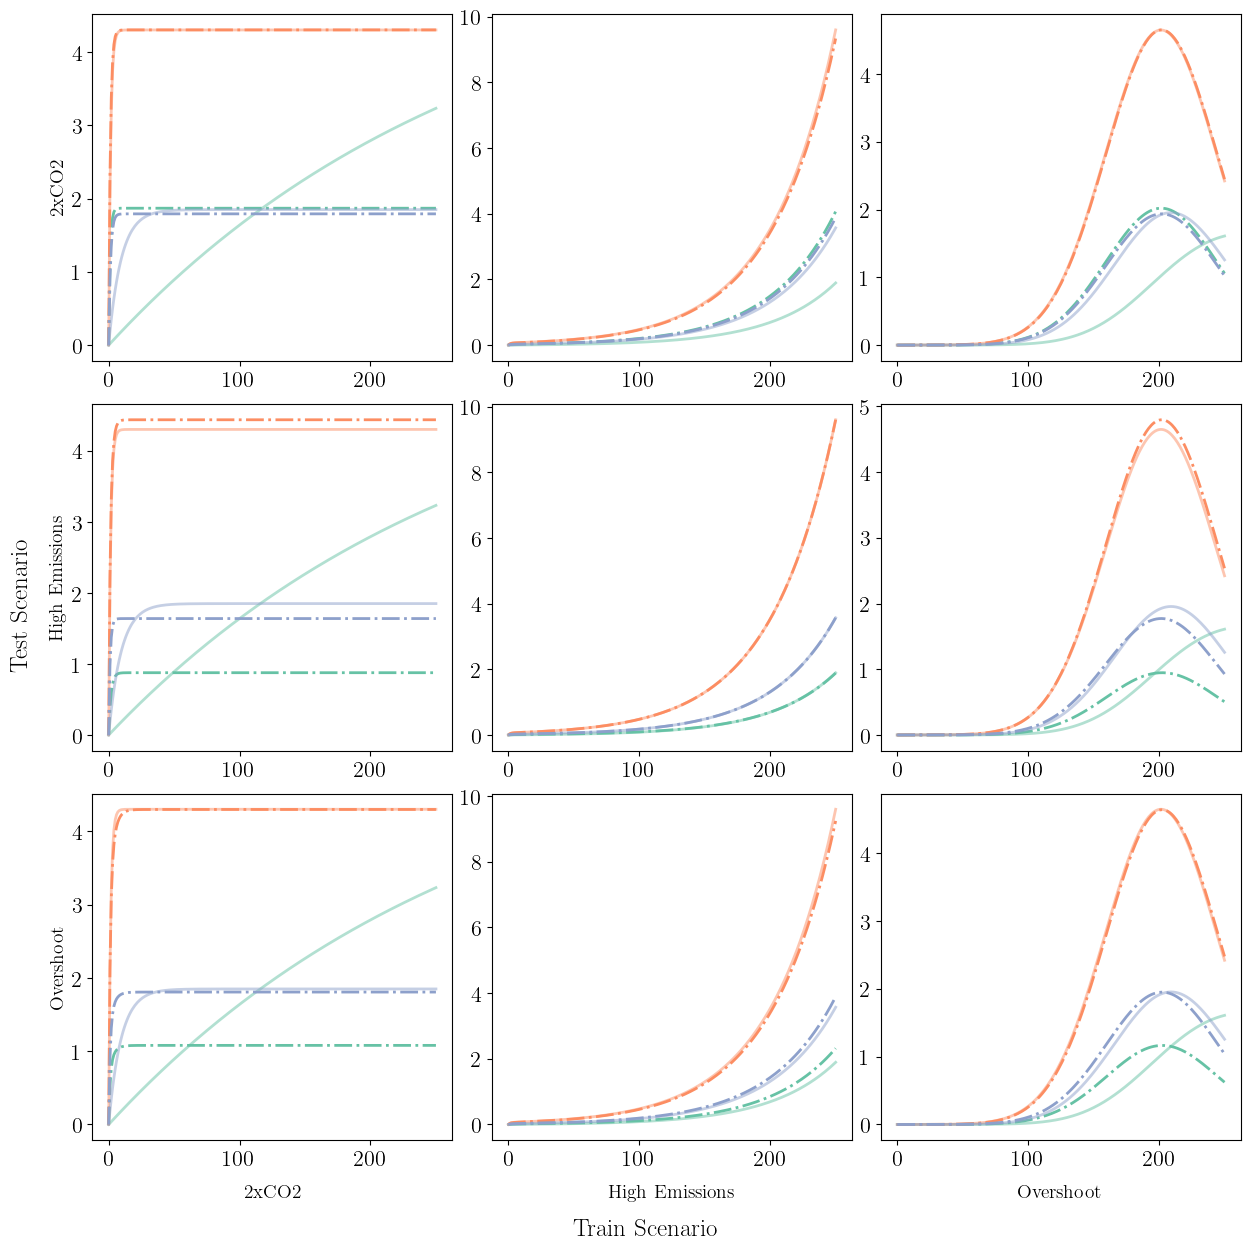

In [221]:
T_out_n = T_out_ensemble
for n in range(1,)
operator_fit, T_pred_fit, error_metrics_fit = emulator_utils.emulate_scenarios('fit_amp', scenarios=scenarios, outputs=T_out, forcings=forcings, t=t, dt=dt, n_boxes=n_boxes, n_modes=3)
emulator_utils.plot_true_pred(T_out, T_pred_fit, scenarios)